In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

In [3]:
import sys 
sys.path.append('../../src')

from spaceoracle.visionary import Visionary
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography


2025-05-05 15:48:30.096749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [4]:
fov = 244
test_adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_lymph_cosmx_{fov}.h5ad')
ref_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
ref_models_dir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/human_tonsil'

ref_adata, test_adata

(AnnData object with n_obs × n_vars = 5778 × 3333
     obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
     uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
     obsm: 'spatial', 'spatial_unscaled'
     layers: 'imputed_count', 'normalized_count',
 AnnData object with n_obs × n_vars = 5225 × 6175
     obs: 'cell_type', 'cell_type_orig'
     uns: 'cell_type_colors', 'cell_type_orig_colors', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
     varm: 'PCs'
     layers: 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances')

In [5]:
# Fill in missing genes as 0 to prevent matrix multiplication errors

ref_genes = ref_adata.var_names

test_gex = test_adata.to_df(layer='normalized_count')
test_gex = test_gex.reindex(ref_genes, axis=1).fillna(0)

test_adata = sc.AnnData(
    X = test_gex.values,
    var = pd.DataFrame(index=test_gex.columns),
    obs = test_adata.obs,
    obsm = test_adata.obsm
)

test_adata.layers['imputed_count'] = test_adata.X
test_adata.layers['normalized_count'] = test_adata.X
test_adata

AnnData object with n_obs × n_vars = 5225 × 3333
    obs: 'cell_type', 'cell_type_orig'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [6]:
matching = pd.read_csv(f'mapping_sp_features_ct_{fov}.csv', index_col=0)
# matching = pd.read_csv('mapping_ct.csv', index_col=0).drop(['test_cell_type', 'ref_cell_type'], axis=1)
matching.head(3)

reference_cell
c_1_244_10    TCTATCAAGCACACAG-1
c_1_244_100   ATACCGAGTACTTCCC-1
c_1_244_1001  TTTCGATTCCGTAATG-1

In [7]:
# some cells are unmapped bc they are cell type not in tonsil
matching = matching.dropna(axis=0)
test_adata = test_adata[matching.index, :]
test_adata

View of AnnData object with n_obs × n_vars = 4340 × 3333
    obs: 'cell_type', 'cell_type_orig'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [8]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

renata = Visionary(
    ref_adata=ref_adata,
    test_adata=test_adata,
    ref_json_path = f'{ref_models_dir}/run_params.json',
    prematching=matching,
    subsample=1,
    matching_annot='cell_type'
)

In [ ]:
target = 'PAX5'
gex = 0

renata.perturb(target, n_propagation=4, save_layer=True)
gex_df = renata.adata.to_df(layer=f'{target}_4n_{gex}x')
gex_df.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_lymph_cosmx_{fov}/{target}_4n_{gex}x.parquet')

In [11]:
# target = 'FOXO1'
# gex = 0

# renata.perturb(target, n_propagation=4, save_layer=True)
# gex_df = renata.adata.to_df(layer=f'{target}_4n_{gex}x')
# gex_df.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_lymph_cosmx_309/{target}_4n_{gex}x.parquet')

In [9]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

In [10]:
# sc.tl.pca(renata.adata, n_comps=50)
# sc.pp.neighbors(renata.adata, use_rep='X_pca')
# sc.tl.umap(renata.adata, min_dist=0.5, spread=0.5)
# sc.pl.umap(renata.adata, color='cell_type')

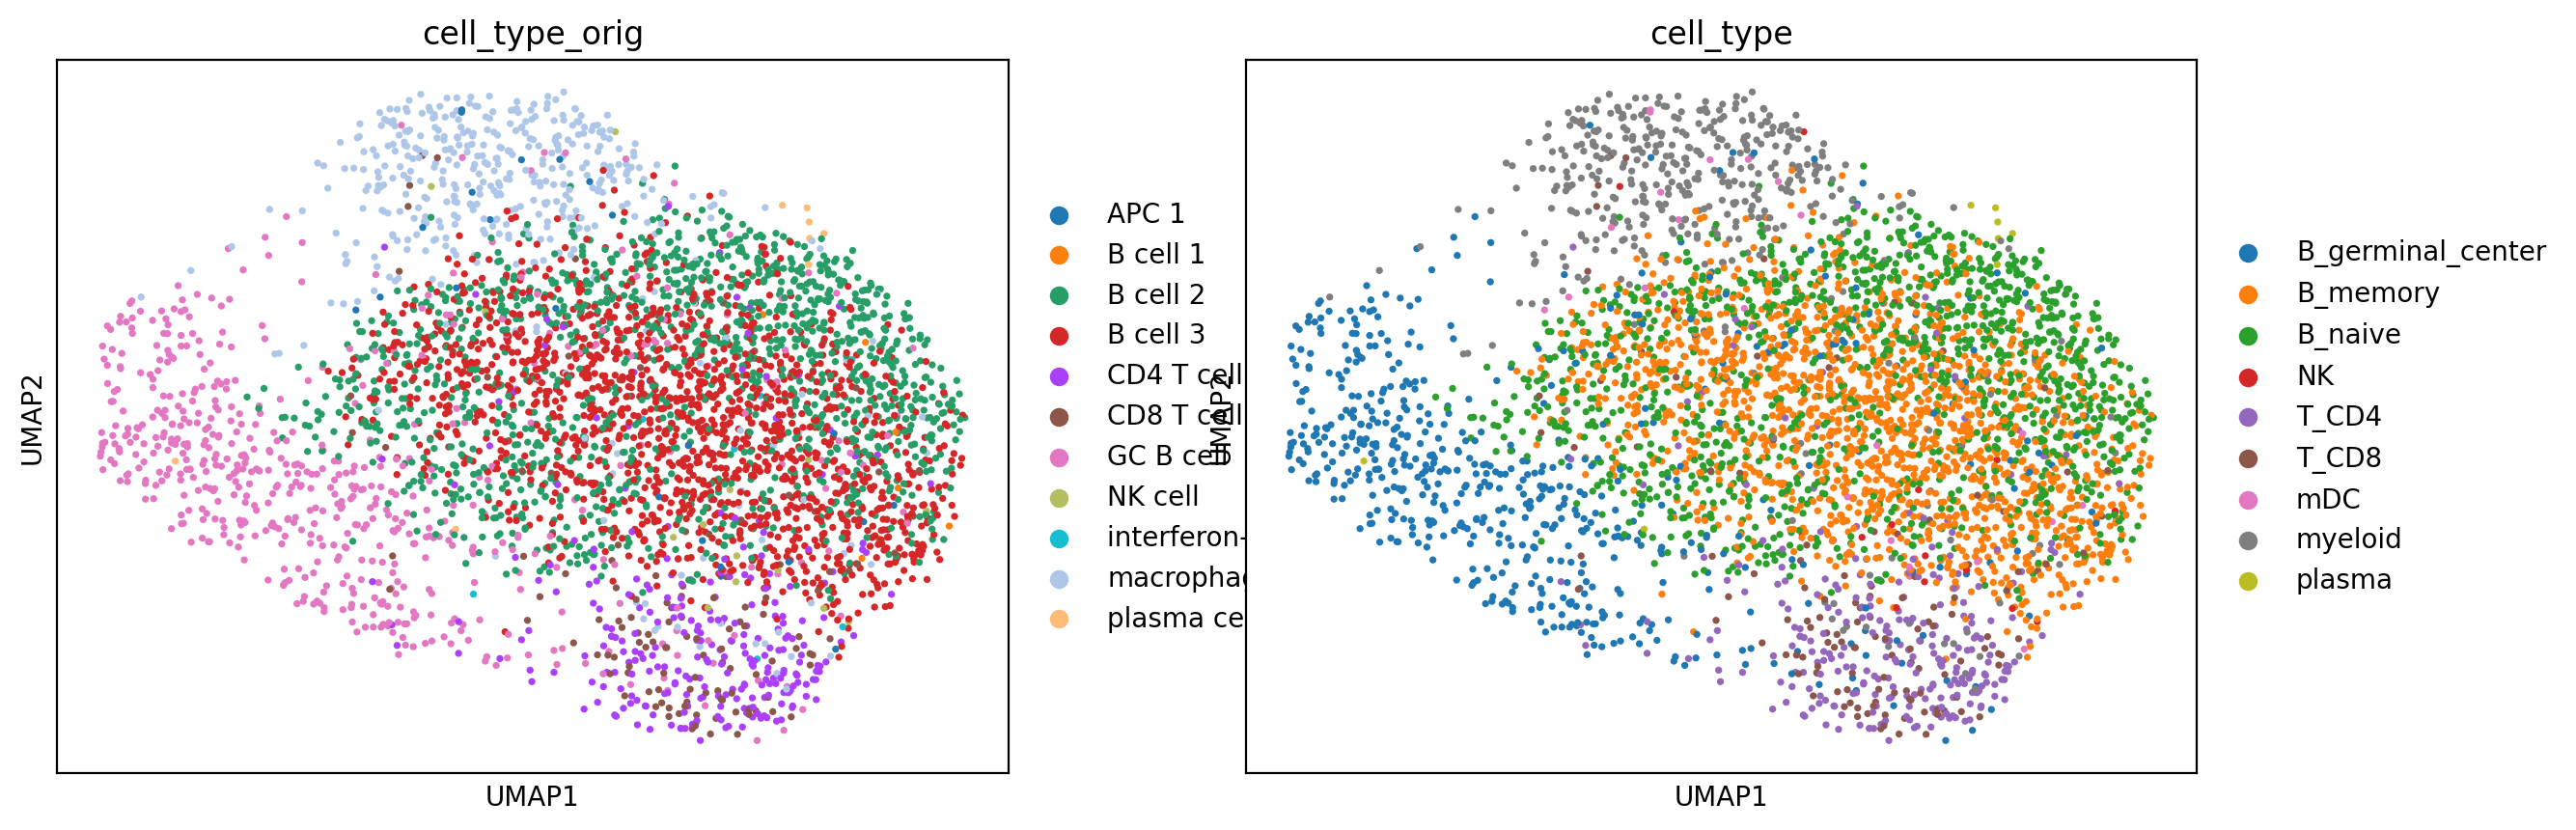

In [11]:
sc.tl.pca(renata.adata, n_comps=50)
sc.pp.neighbors(renata.adata, use_rep='X_pca')
sc.tl.umap(renata.adata, min_dist=0.5, spread=1)
sc.pl.umap(renata.adata, color=['cell_type_orig', 'cell_type'])

In [17]:
colors = ["#bb5f65",
"#60af4b",
"#b257c5",
"#bab246",
"#6773d8",
"#cb8543",
"#5b9fd5",
"#cf4d39",
"#4bad89",
"#d04483",
"#727732",
"#7a5695",
"#d088c4",
""]


# color_dict = {ct: color for ct, color in zip(renata.adata.obs['cell_type_orig'].unique(), colors)}
color_dict = {ct: color for ct, color in zip(renata.adata.obs['cell_type'].unique(), colors)}

chart = Cartography(renata.adata, color_dict)

In [13]:
renata.adata.obs['cell_type'].unique()

['B_germinal_center', 'myeloid', 'B_memory', 'T_CD4', 'B_naive', 'mDC', 'T_CD8', 'NK', 'plasma']
Categories (9, object): ['B_germinal_center', 'B_memory', 'B_naive', 'NK', ..., 'T_CD8', 'mDC', 'myeloid', 'plasma']

In [14]:
from tqdm import tqdm

max_dist = 1.5
remove_cells = []

for ct in tqdm(chart.adata.obs['cell_type'].unique()):
    mask = chart.adata.obs['cell_type'] == ct
    coords = chart.adata.obsm['X_umap'][mask]
    
    # Compute median x and y for the current cell type
    x = np.median(coords[:, 0])
    y = np.median(coords[:, 1])
    
    # Compute distances from the median
    distances = np.sqrt((coords[:, 0] - x) ** 2 + (coords[:, 1] - y) ** 2)
    
    # Identify cells farther than max_dist
    to_remove = mask[mask].index[distances > max_dist]
    remove_cells.extend(to_remove)

# Drop the distant cells from the AnnData object
chart.adata = chart.adata[~chart.adata.obs_names.isin(remove_cells)]
chart.adata

View of AnnData object with n_obs × n_vars = 1624 × 3333
    obs: 'cell_type', 'cell_type_orig', 'cell_type_int', 'reference_cell'
    uns: 'cell_thresholds', 'pca', 'neighbors', 'umap', 'cell_type_orig_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [15]:
chart.color_dict

{'B_germinal_center': '#bb5f65',
 'myeloid': '#60af4b',
 'B_memory': '#b257c5',
 'T_CD4': '#bab246',
 'B_naive': '#6773d8',
 'mDC': '#cb8543',
 'T_CD8': '#5b9fd5',
 'NK': '#cf4d39',
 'plasma': '#4bad89'}

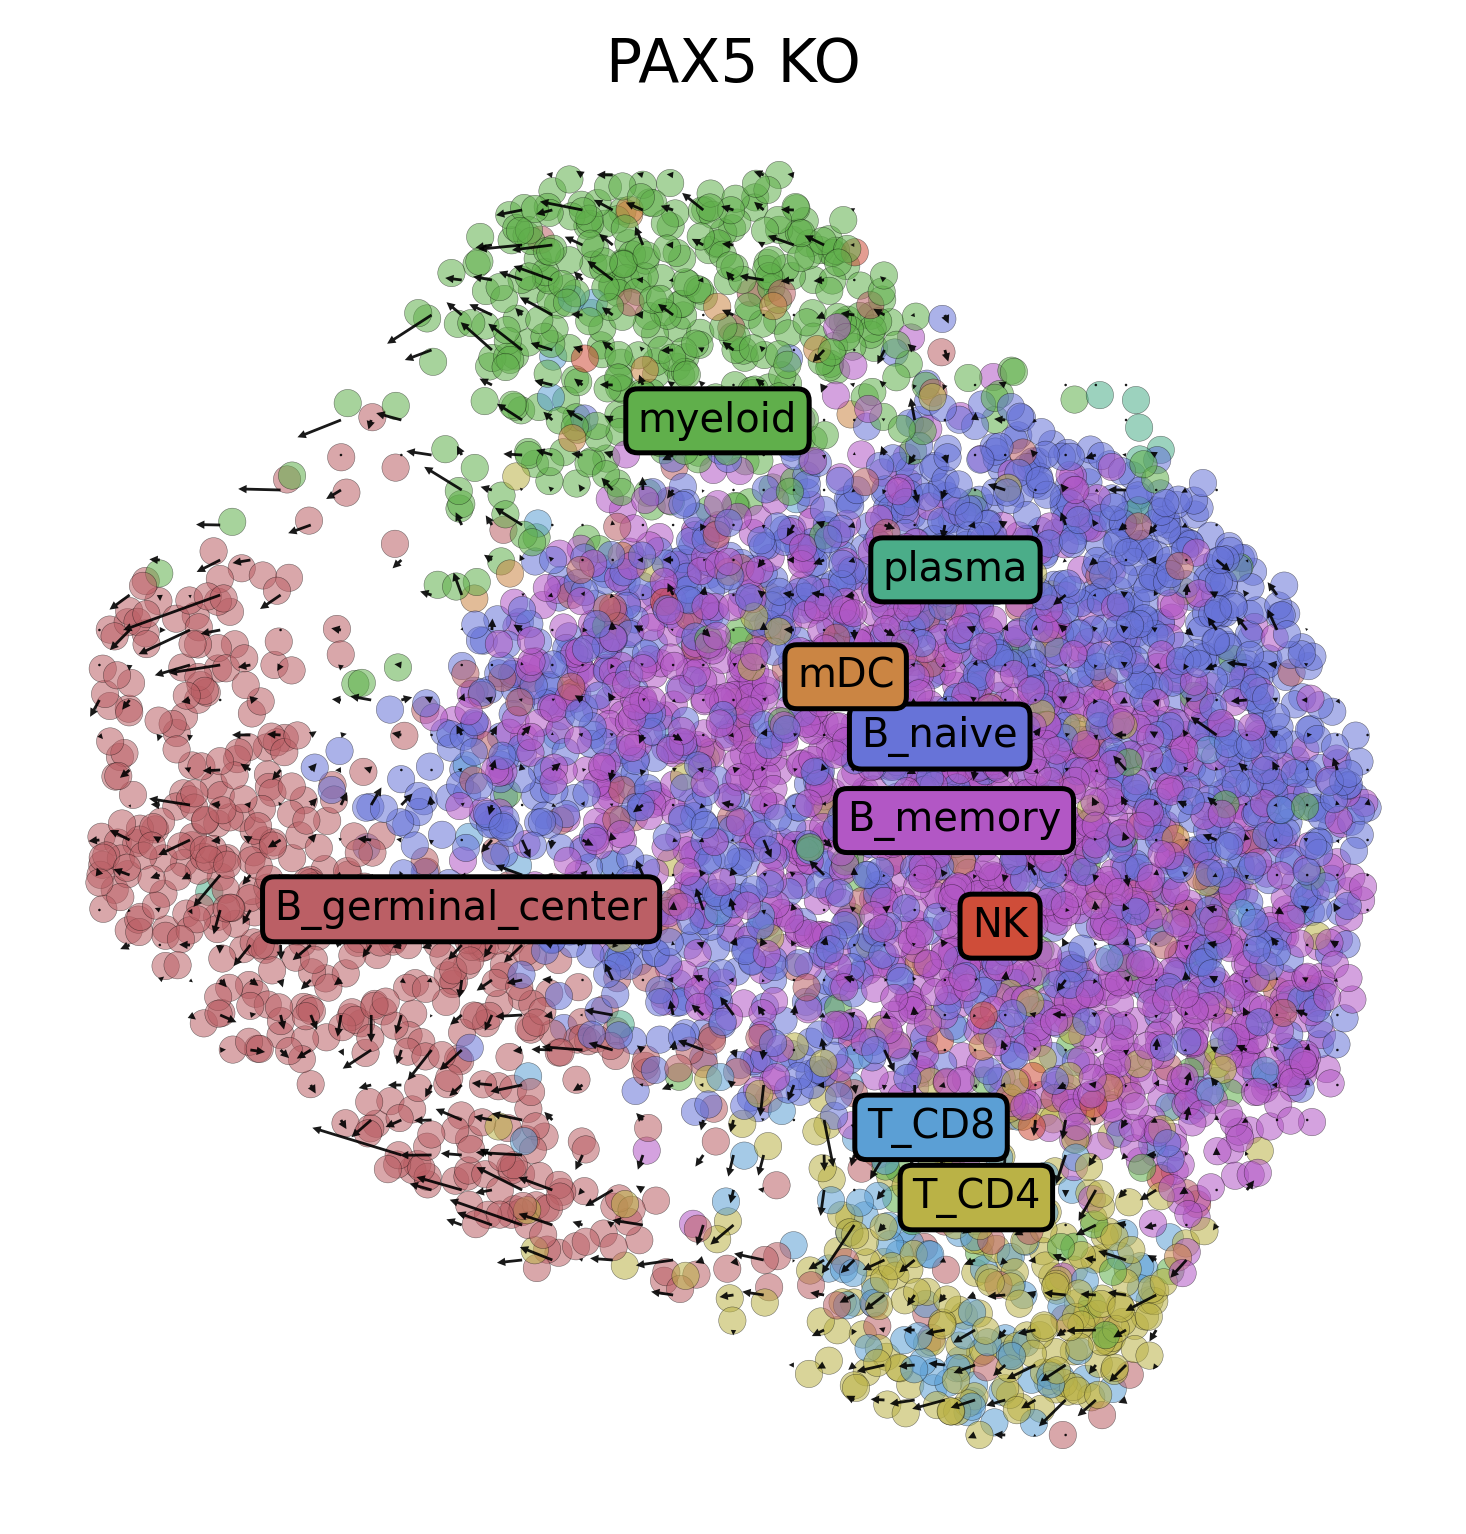

In [18]:
kotarget = 'PAX5'
grid, vec = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=6.0,
    vector_scale=0.2,
    n_neighbors=70,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.55,
    scatter_size=30,
    remove_null=True,
    betadata_path=f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_lymph_cosmx_{fov}/',
    legend_on_loc=True,
)
plt.title(f'{kotarget} KO')
plt.show()

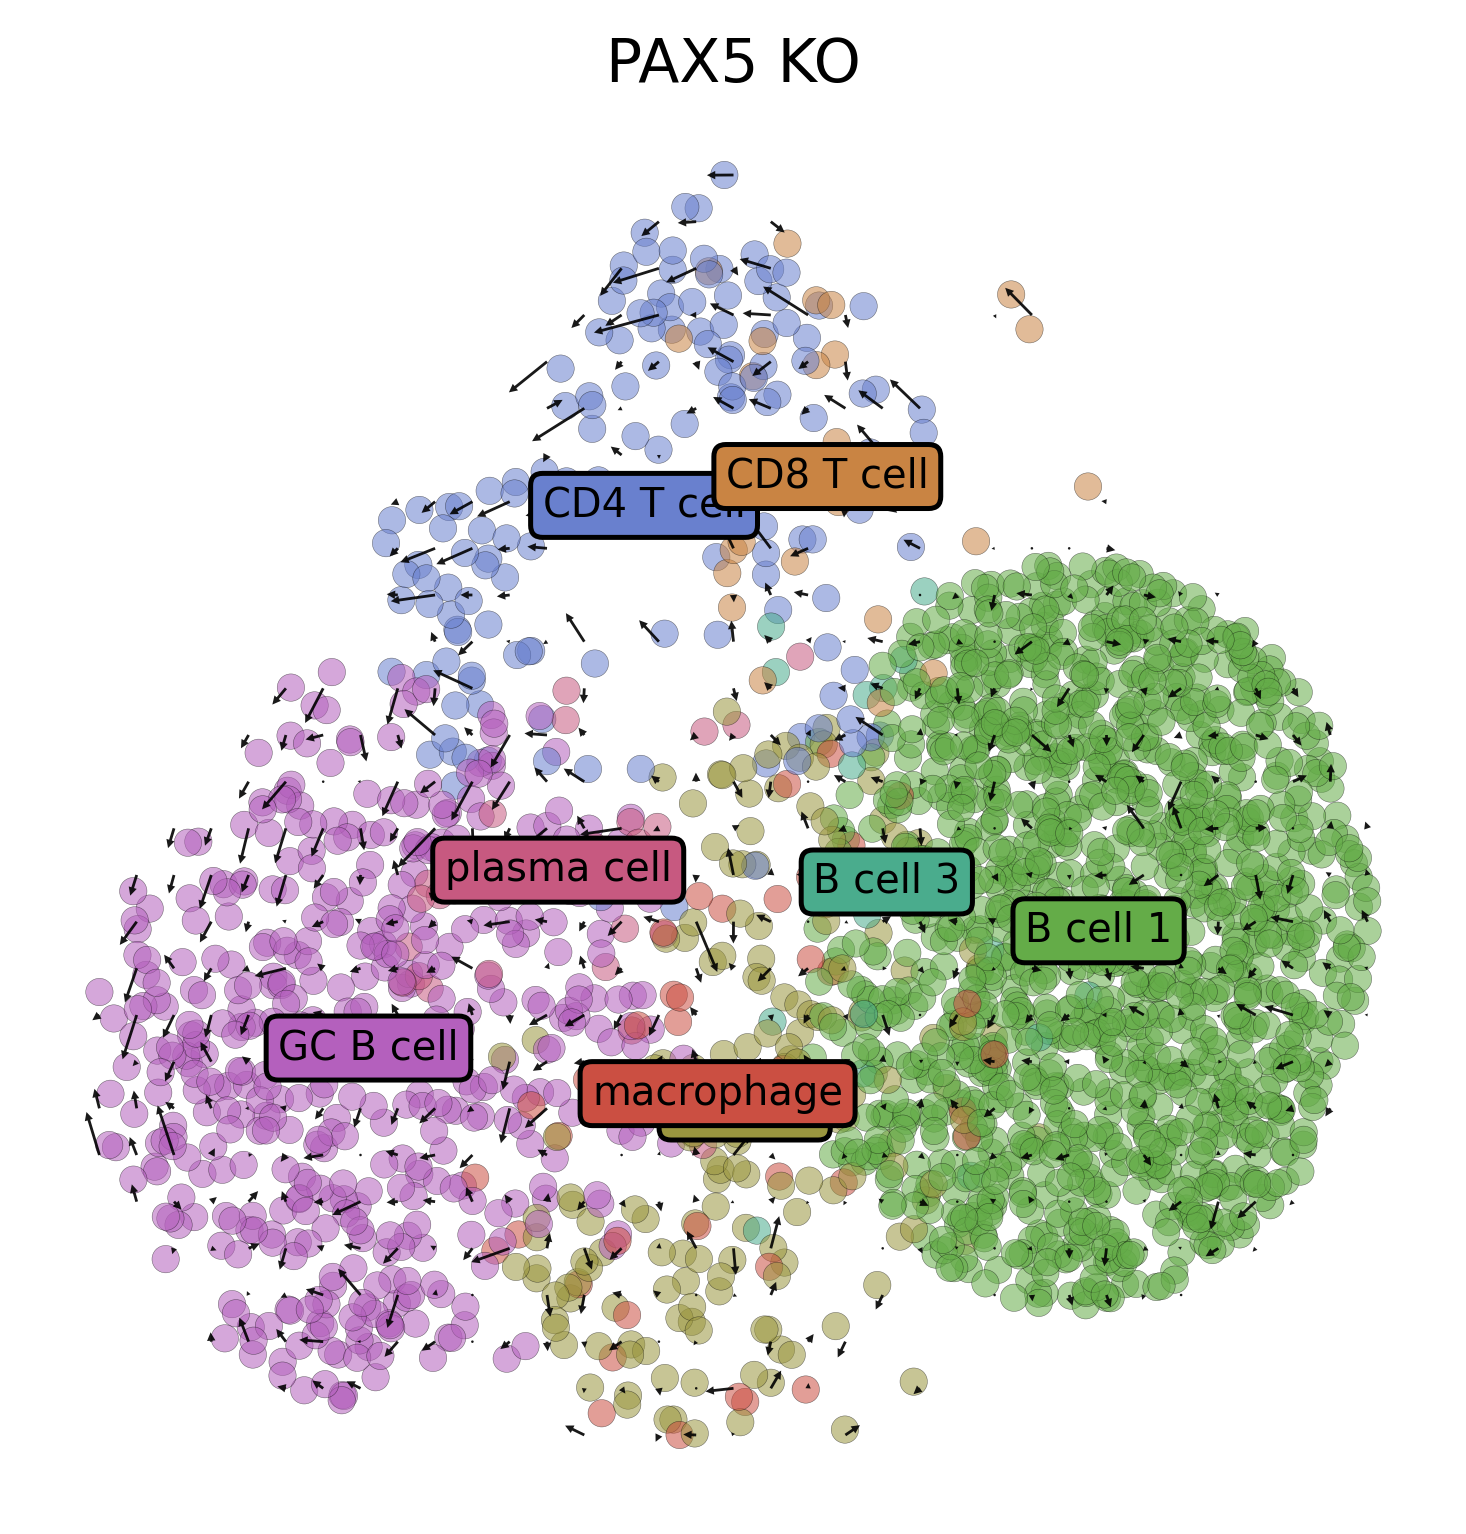

In [ ]:
kotarget = 'PAX5'
grid, vec = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=6.0,
    vector_scale=0.2,
    n_neighbors=70,
    figsize=(5, 5), 
    hue='cell_type_orig',
    alpha=0.55,
    scatter_size=30,
    remove_null=True,
    betadata_path='/ix/djishnu/shared/djishnu_kor11/genome_screens/human_lymph_cosmx_309/',
    legend_on_loc=True,
)
plt.title(f'{kotarget} KO')
plt.show()